Étape 1. Autoencodeur simple

In [16]:
import os, warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [17]:
data = fetch_olivetti_faces()
X, y = data.images, data.target
n_samples, h, w = X.shape
input_dim = h * w  # 4096 pixels

print(f" Dataset: {n_samples} images de {h}x{w} = {input_dim} pixels")

 Dataset: 400 images de 64x64 = 4096 pixels


In [18]:
X_flat = X.reshape(n_samples, input_dim).astype('float32')
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)
print(f" Shapes: X_train {X_train.shape}, X_test {X_test.shape}")

 Shapes: X_train (320, 4096), X_test (80, 4096)


   PCA avec 10 composantes...
      MSE train: 0.006621, test: 0.006848
      Variance expliquée: 65.5%
   PCA avec 32 composantes...
      MSE train: 0.003299, test: 0.004002
      Variance expliquée: 82.8%
   PCA avec 64 composantes...
      MSE train: 0.001865, test: 0.003026
      Variance expliquée: 90.3%
   PCA avec 128 composantes...
      MSE train: 0.000770, test: 0.002260
      Variance expliquée: 96.0%
   PCA avec 256 composantes...
      MSE train: 0.000094, test: 0.001688
      Variance expliquée: 99.5%


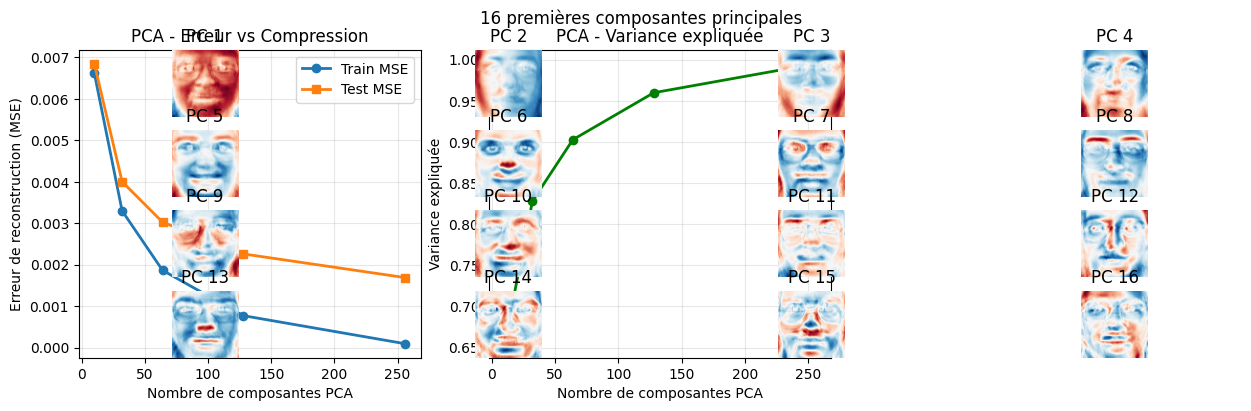

In [21]:
#comparaison avec PCA
pca_components = [10, 32, 64, 128, 256]
pca_results = {}

for n_comp in pca_components:
    print(f"   PCA avec {n_comp} composantes...")
    pca = PCA(n_components=n_comp, random_state=42)
    
    # Fit sur train, transform sur train et test
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Reconstruction
    X_train_reconstructed = pca.inverse_transform(X_train_pca)
    X_test_reconstructed = pca.inverse_transform(X_test_pca)
    
    # Erreur de reconstruction
    train_mse = mean_squared_error(X_train, X_train_reconstructed)
    test_mse = mean_squared_error(X_test, X_test_reconstructed)
    
    # Variance
    explained_var = np.sum(pca.explained_variance_ratio_)
    
    pca_results[n_comp] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'explained_variance': explained_var,
        'pca_model': pca
    }
    
    print(f"      MSE train: {train_mse:.6f}, test: {test_mse:.6f}")
    print(f"      Variance expliquée: {explained_var*100:.1f}%")

# résultats PCA
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Erreur de reconstruction vs nb composantes
components = list(pca_results.keys())
train_mses = [pca_results[c]['train_mse'] for c in components]
test_mses = [pca_results[c]['test_mse'] for c in components]

axes[0].plot(components, train_mses, 'o-', label='Train MSE', linewidth=2)
axes[0].plot(components, test_mses, 's-', label='Test MSE', linewidth=2)
axes[0].set_xlabel('Nombre de composantes PCA')
axes[0].set_ylabel('Erreur de reconstruction (MSE)')
axes[0].set_title('PCA - Erreur vs Compression')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Variance
explained_vars = [pca_results[c]['explained_variance'] for c in components]
axes[1].plot(components, explained_vars, 'o-', color='green', linewidth=2)
axes[1].set_xlabel('Nombre de composantes PCA')
axes[1].set_ylabel('Variance expliquée')
axes[1].set_title('PCA - Variance expliquée')
axes[1].grid(True, alpha=0.3)

# Premières composantes principales (64 composantes)
pca_64 = pca_results[64]['pca_model']
components_img = pca_64.components_[:16].reshape(16, h, w)
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(components_img[i], cmap='RdBu_r')
    plt.title(f'PC {i+1}')
    plt.axis('off')

plt.suptitle('16 premières composantes principales', y=0.98)
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [8]:
# AUTOENCODEUR SIMPLE
def create_simple_autoencoder(input_dim, encoding_dim):
    """Autoencodeur simple avec une couche d'encodage et une de décodage"""
    
    # Architecture séquentielle
    autoencoder = Sequential(name=f"SimpleAutoencoder_{encoding_dim}")
    
    # Encodeur
    autoencoder.add(Dense(encoding_dim, input_shape=(input_dim,), 
                         activation='relu', name='encoder'))
    
    # Décodeur
    autoencoder.add(Dense(input_dim, activation='sigmoid', name='decoder'))
    
    autoencoder.build(input_shape=(None, input_dim))
    
    encoder = Model(autoencoder.input, autoencoder.layers[0].output, name='encoder')
    
    return autoencoder, encoder

def create_simple_autoencoder_functional(input_dim, encoding_dim):
    
    # Input layer
    input_layer = Input(shape=(input_dim,), name='input')
    
    # Encodeur
    encoded = Dense(encoding_dim, activation='relu', name='encoder')(input_layer)
    
    # Décodeur  
    decoded = Dense(input_dim, activation='sigmoid', name='decoder')(encoded)
    
    # Modèles
    autoencoder = Model(input_layer, decoded, name=f"SimpleAutoencoder_{encoding_dim}")
    encoder = Model(input_layer, encoded, name='encoder')
    
    return autoencoder, encoder

# dimensions
encoding_dims = [32, 64, 128, 256]
autoencoder_results = {}

for encoding_dim in encoding_dims:
    print(f"\n Entraînement autoencodeur simple - dimension {encoding_dim}")
    
    # Création du modèle
    autoencoder, encoder = create_simple_autoencoder_functional(input_dim, encoding_dim)
    
    print(f" Architecture:")
    autoencoder.summary()
    
    # Compilation
    autoencoder.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mse',  # Mean Squared Error pour la reconstruction
        metrics=['mae']
    )
    
    # Callbacks
    early = EarlyStopping(patience=15, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=8, min_lr=1e-6, verbose=0)
    
    # (input = output pour autoencodeur)
    history = autoencoder.fit(
        X_train, X_train,  # Input = Output !
        epochs=100,
        batch_size=32,
        validation_data=(X_test, X_test),
        callbacks=[early, reduce_lr],
        verbose=1
    )
    
    train_loss = autoencoder.evaluate(X_train, X_train, verbose=0)[0]
    test_loss = autoencoder.evaluate(X_test, X_test, verbose=0)[0]
    
    X_train_encoded = encoder.predict(X_train, verbose=0)
    X_test_encoded = encoder.predict(X_test, verbose=0)
    
    X_train_reconstructed = autoencoder.predict(X_train, verbose=0)
    X_test_reconstructed = autoencoder.predict(X_test, verbose=0)
    
    autoencoder_results[encoding_dim] = {
        'autoencoder': autoencoder,
        'encoder': encoder,
        'history': history,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'X_train_encoded': X_train_encoded,
        'X_test_encoded': X_test_encoded,
        'X_train_reconstructed': X_train_reconstructed,
        'X_test_reconstructed': X_test_reconstructed
    }
    
    print(f"    MSE train: {train_loss:.6f}, test: {test_loss:.6f}")


 Entraînement autoencodeur simple - dimension 32
 Architecture:


Model: "SimpleAutoencoder_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Dense)                 │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 4096)           │       135,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,272 (1.02 MB)

 Trainable params: 266,272 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0314 - mae: 0.1472 - val_loss: 0.0283 - val_mae: 0.1381 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0254 - mae: 0.1295 - val_loss: 0.0214 - val_mae: 0.1175 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0200 - mae: 0.1132 - val_loss: 0.0192 - val_mae: 0.1104 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0189 - mae: 0.1094 - val_loss: 0.0186 - val_mae: 0.1077 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0179 - mae: 0.1058 - val_loss: 0.0184 - val_mae: 0.1065 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0175 - mae: 0.1040 - val_loss: 0.0181 - val_mae: 0.1061 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0168 - mae: 0.1023 - val_loss: 0.0180 - val_mae: 0.1053 - learning_rate: 0.0010
Epoch 

Model: "SimpleAutoencoder_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 4096)           │       266,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,448 (2.02 MB)

 Trainable params: 528,448 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0314 - mae: 0.1463 - val_loss: 0.0267 - val_mae: 0.1333 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0248 - mae: 0.1279 - val_loss: 0.0208 - val_mae: 0.1161 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0195 - mae: 0.1119 - val_loss: 0.0191 - val_mae: 0.1106 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0184 - mae: 0.1077 - val_loss: 0.0185 - val_mae: 0.1073 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0179 - mae: 0.1055 - val_loss: 0.0182 - val_mae: 0.1069 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0180 - mae: 0.1061 - val_loss: 0.0182 - val_mae: 0.1073 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0175 - mae: 0.1045 - val_loss: 0.0179 - val_mae: 0.1059 - learning_rate: 0.0010
Epoch 

Model: "SimpleAutoencoder_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 4096)           │       528,384 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,800 (4.02 MB)

 Trainable params: 1,052,800 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0314 - mae: 0.1463 - val_loss: 0.0257 - val_mae: 0.1308 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0230 - mae: 0.1227 - val_loss: 0.0196 - val_mae: 0.1121 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0183 - mae: 0.1074 - val_loss: 0.0187 - val_mae: 0.1081 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0177 - mae: 0.1053 - val_loss: 0.0183 - val_mae: 0.1075 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0171 - mae: 0.1033 - val_loss: 0.0179 - val_mae: 0.1061 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0172 - mae: 0.1029 - val_loss: 0.0174 - val_mae: 0.1043 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0168 - mae: 0.1018 - val_loss: 0.0167 - val_mae: 0.1011 - learning_rate: 0.0010
Epoch 

Model: "SimpleAutoencoder_256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 4096)           │     1,052,672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101,504 (8.02 MB)

 Trainable params: 2,101,504 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0308 - mae: 0.1437 - val_loss: 0.0209 - val_mae: 0.1161 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0201 - mae: 0.1132 - val_loss: 0.0188 - val_mae: 0.1084 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0179 - mae: 0.1058 - val_loss: 0.0179 - val_mae: 0.1062 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0173 - mae: 0.1032 - val_loss: 0.0173 - val_mae: 0.1042 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0170 - mae: 0.1032 - val_loss: 0.0162 - val_mae: 0.1000 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0158 - mae: 0.0984 - val_loss: 0.0150 - val_mae: 0.0967 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0150 - mae: 0.0961 - val_loss: 0.0142 - val_mae: 0.0924 - learning_rate: 0.0010
Epoch 

In [9]:
# AUTOENCODEUR COMPLEXE
def create_complex_autoencoder(input_dim, encoding_dim):
    """Autoencodeur avec plusieurs couches et goulot d'étranglement"""
    
    input_layer = Input(shape=(input_dim,), name='input')
    
    # Encodeur progressif
    encoded = Dense(1024, activation='relu', name='enc_1024')(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(512, activation='relu', name='enc_512')(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(256, activation='relu', name='enc_256')(encoded)
    encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Décodeur progressif (symétrique)
    decoded = Dense(256, activation='relu', name='dec_256')(encoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(512, activation='relu', name='dec_512')(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(1024, activation='relu', name='dec_1024')(decoded)
    decoded = Dense(input_dim, activation='sigmoid', name='output')(decoded)
    
    # Modèles
    autoencoder = Model(input_layer, decoded, name=f'ComplexAutoencoder_{encoding_dim}')
    encoder = Model(input_layer, encoded, name=f'ComplexEncoder_{encoding_dim}')
    
    return autoencoder, encoder

best_dim = 64
print(f" Entraînement autoencodeur complexe - dimension {best_dim}")

complex_autoencoder, complex_encoder = create_complex_autoencoder(input_dim, best_dim)

print(" Architecture complexe:")
complex_autoencoder.summary()

# Compilation
complex_autoencoder.compile(
    optimizer=Adam(learning_rate=5e-4),  # Learning rate plus faible
    loss='mse',
    metrics=['mae']
)

early = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=10, min_lr=1e-7, verbose=1)

complex_history = complex_autoencoder.fit(
    X_train, X_train,
    epochs=150,
    batch_size=16,  # Batch plus petit pour modèle complexe
    validation_data=(X_test, X_test),
    callbacks=[early, reduce_lr],
    verbose=1
)

complex_train_loss = complex_autoencoder.evaluate(X_train, X_train, verbose=0)[0]
complex_test_loss = complex_autoencoder.evaluate(X_test, X_test, verbose=0)[0]

print(f" Autoencodeur complexe - MSE train: {complex_train_loss:.6f}, test: {complex_test_loss:.6f}")

 Entraînement autoencodeur complexe - dimension 64
 Architecture complexe:


Model: "ComplexAutoencoder_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_1024 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_512 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_256 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_256 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_512 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_1024 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4096)           │     4,198,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,739,840 (37.15 MB)

 Trainable params: 9,739,840 (37.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0277 - mae: 0.1356 - val_loss: 0.0209 - val_mae: 0.1185 - learning_rate: 5.0000e-04
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0188 - mae: 0.1092 - val_loss: 0.0190 - val_mae: 0.1110 - learning_rate: 5.0000e-04
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0182 - mae: 0.1069 - val_loss: 0.0191 - val_mae: 0.1115 - learning_rate: 5.0000e-04
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0183 - mae: 0.1068 - val_loss: 0.0183 - val_mae: 0.1079 - learning_rate: 5.0000e-04
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0182 - mae: 0.1061 - val_loss: 0.0184 - val_mae: 0.1083 - learning_rate: 5.0000e-04
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0181 - mae: 0.1061 - val_loss: 0.0184 - val_mae: 0.1082 - learning_rate: 5.0000e-04
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0179 - mae: 0.1055 - val_loss: 0.0181 - val_mae: 0.1070

In [10]:
# COMPARAISON DES MÉTHODES
best_pca_64 = pca_results[64]
best_simple_ae = autoencoder_results[64]

comparison_data = {
    'Méthode': ['PCA 64', 'Autoencodeur Simple 64', 'Autoencodeur Complexe 64'],
    'MSE Train': [best_pca_64['train_mse'], best_simple_ae['train_loss'], complex_train_loss],
    'MSE Test': [best_pca_64['test_mse'], best_simple_ae['test_loss'], complex_test_loss],
    'Paramètres': ['0 (transformation linéaire)', f'{64*input_dim + input_dim}', complex_autoencoder.count_params()]
}

import pandas as pd
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

                 Méthode  MSE Train  MSE Test                  Paramètres
                  PCA 64   0.001865  0.003026 0 (transformation linéaire)
  Autoencodeur Simple 64   0.009651  0.010266                      266240
Autoencodeur Complexe 64   0.010069  0.010909                     9739840


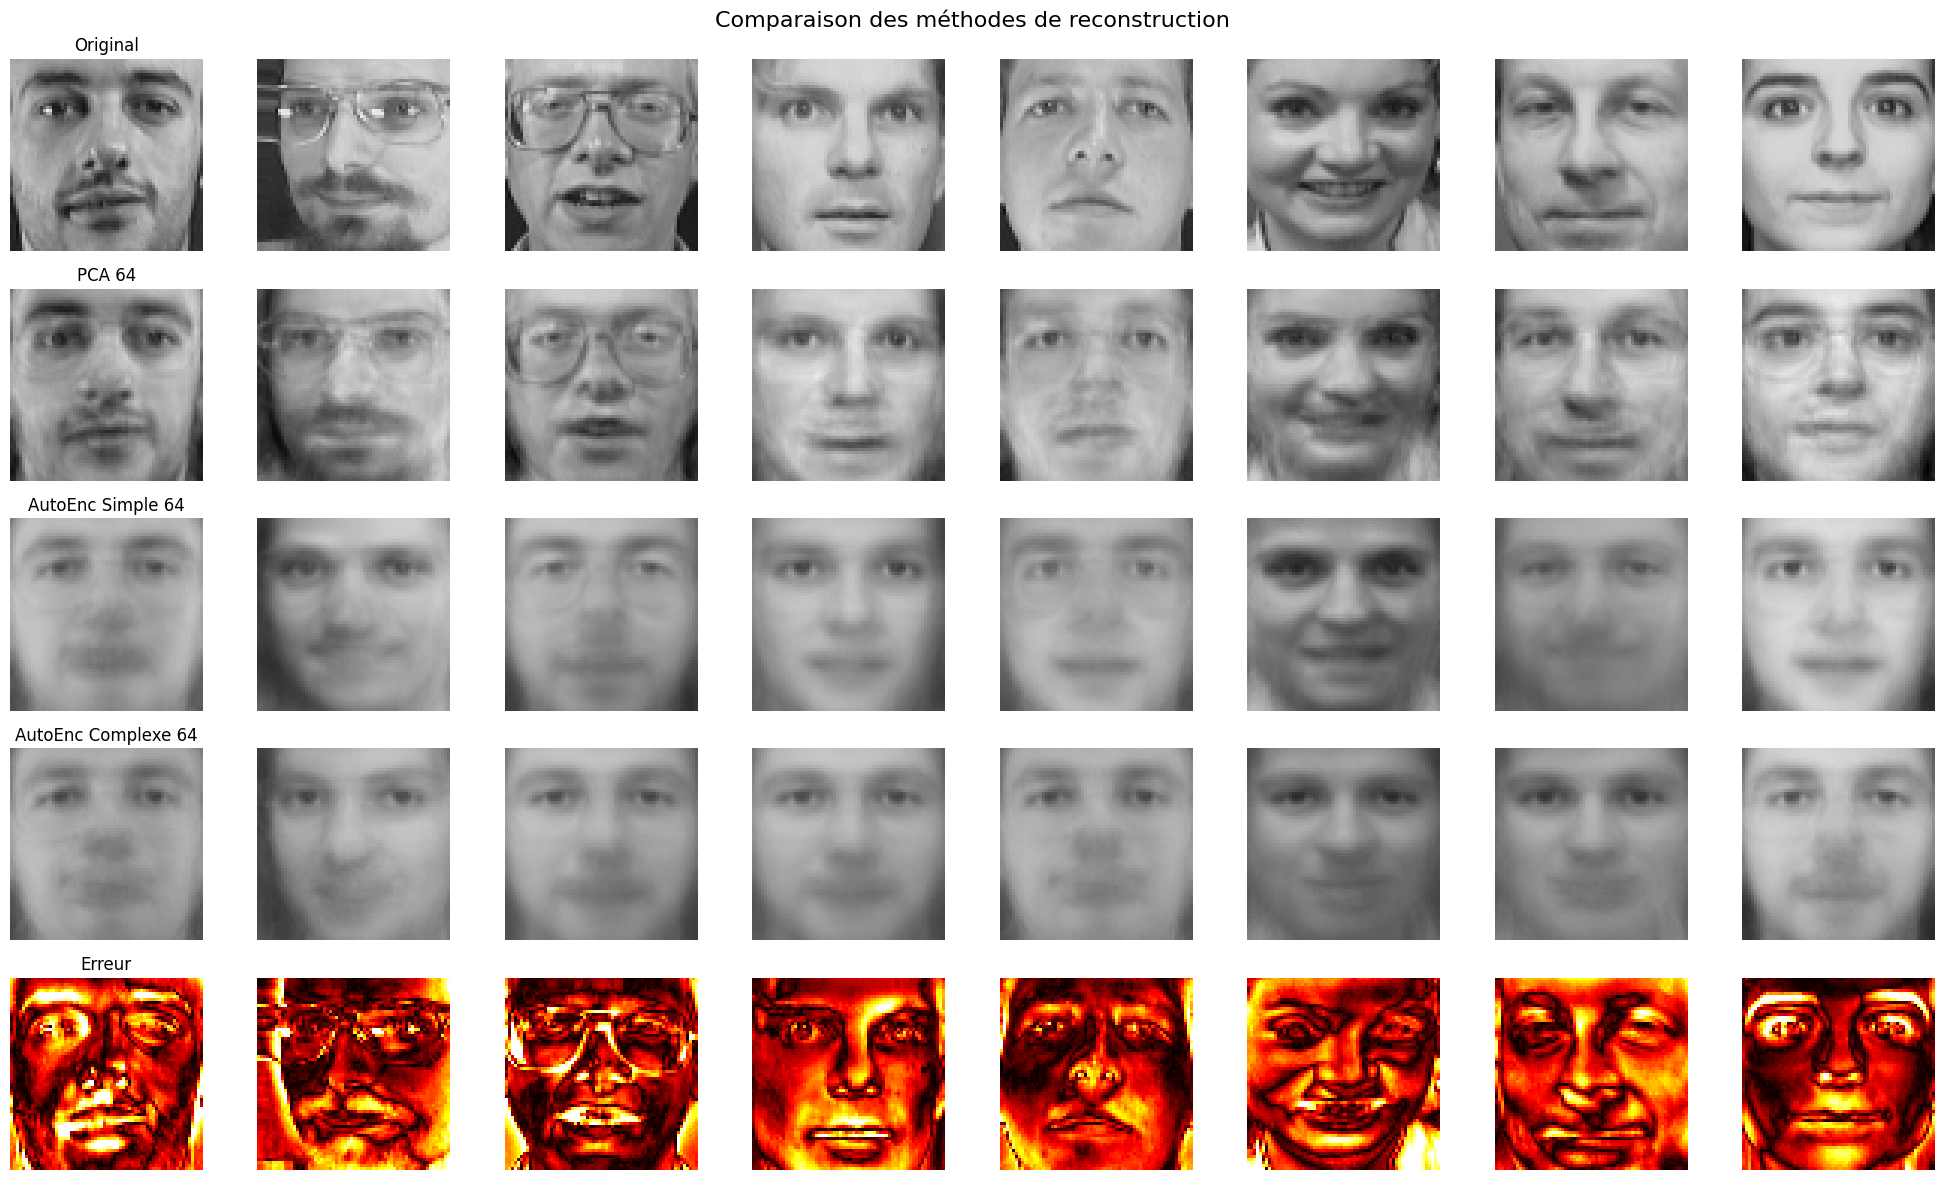

In [11]:
n_examples = 8
test_indices = np.random.choice(len(X_test), n_examples, replace=False)

pca_64_model = best_pca_64['pca_model']
X_test_pca_encoded = pca_64_model.transform(X_test[test_indices])
X_test_pca_reconstructed = pca_64_model.inverse_transform(X_test_pca_encoded)

simple_ae_reconstructed = best_simple_ae['autoencoder'].predict(X_test[test_indices], verbose=0)
complex_ae_reconstructed = complex_autoencoder.predict(X_test[test_indices], verbose=0)

fig, axes = plt.subplots(5, n_examples, figsize=(20, 12))

methods = ['Original', 'PCA 64', 'AutoEnc Simple 64', 'AutoEnc Complexe 64', 'Différence']
reconstructions = [
    X_test[test_indices],
    X_test_pca_reconstructed, 
    simple_ae_reconstructed,
    complex_ae_reconstructed
]

for j in range(n_examples):
    for i, (method, recon) in enumerate(zip(methods[:-1], reconstructions)):
        img = recon[j].reshape(h, w)
        axes[i, j].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i, j].set_title(f'{method}' if j == 0 else '')
        axes[i, j].axis('off')
    
    # erreur de reconstruction
    original = X_test[test_indices[j]].reshape(h, w)
    complex_recon = complex_ae_reconstructed[j].reshape(h, w)
    diff = np.abs(original - complex_recon)
    
    im = axes[4, j].imshow(diff, cmap='hot', vmin=0, vmax=0.3)
    axes[4, j].set_title('Erreur' if j == 0 else '')
    axes[4, j].axis('off')

plt.suptitle('Comparaison des méthodes de reconstruction', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

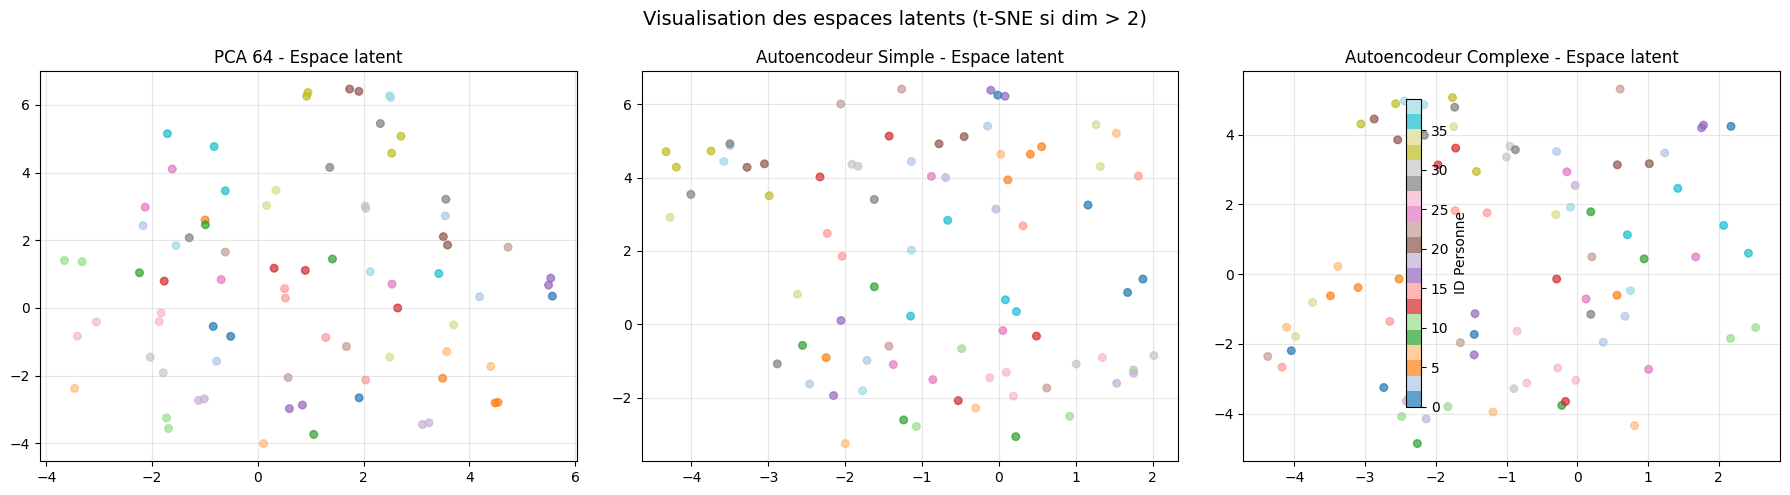

In [12]:
# ESPACE LATENT
X_test_simple_encoded = best_simple_ae['encoder'].predict(X_test, verbose=0)
X_test_complex_encoded = complex_encoder.predict(X_test, verbose=0)
X_test_pca_encoded_full = pca_64_model.transform(X_test)

# Visualisation 2D avec t-SNE (si dimension > 2)
from sklearn.manifold import TSNE

def plot_latent_2d(encoded_data, labels, title, ax):
    if encoded_data.shape[1] > 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        encoded_2d = tsne.fit_transform(encoded_data)
    else:
        encoded_2d = encoded_data
    
    scatter = ax.scatter(encoded_2d[:, 0], encoded_2d[:, 1], 
                        c=labels, cmap='tab20', alpha=0.7, s=30)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    return scatter

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_latent_2d(X_test_pca_encoded_full, y_test, 'PCA 64 - Espace latent', axes[0])
plot_latent_2d(X_test_simple_encoded, y_test, 'Autoencodeur Simple - Espace latent', axes[1])
scatter = plot_latent_2d(X_test_complex_encoded, y_test, 'Autoencodeur Complexe - Espace latent', axes[2])

plt.colorbar(scatter, ax=axes, label='ID Personne', shrink=0.8)
plt.suptitle('Visualisation des espaces latents (t-SNE si dim > 2)', fontsize=14)
plt.tight_layout()
plt.show()

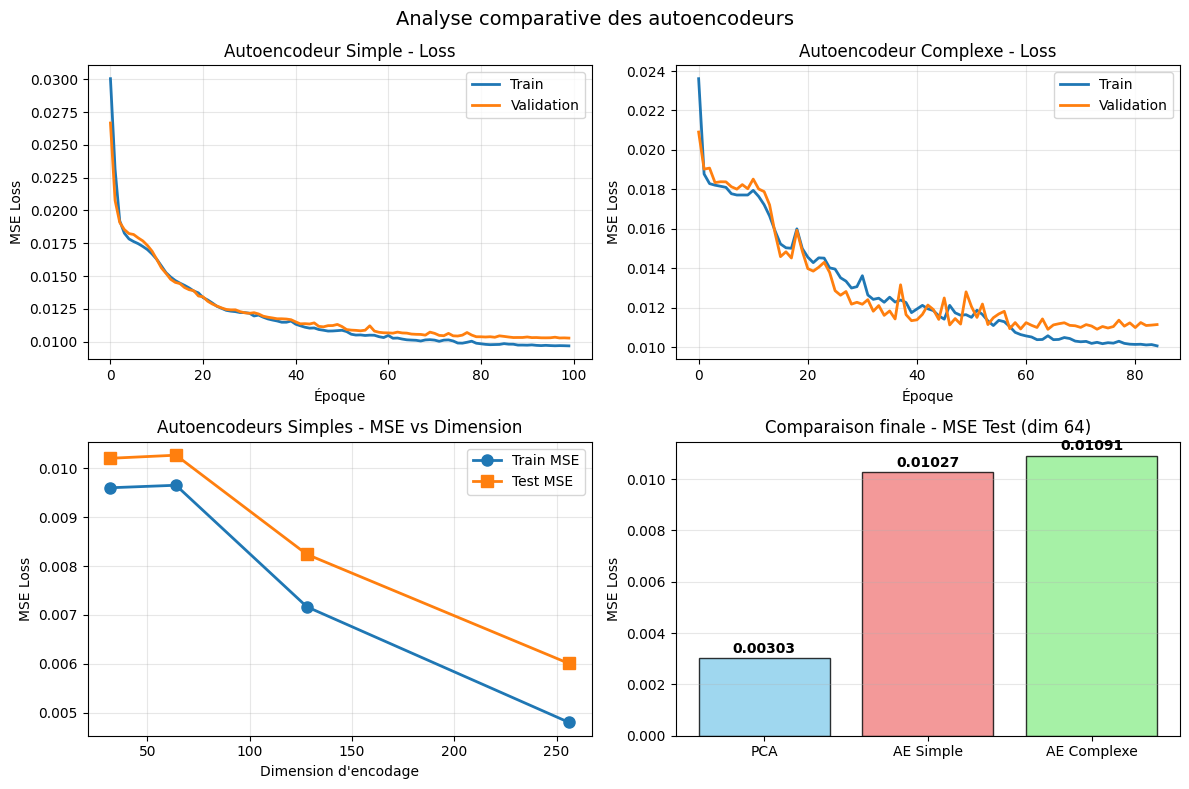

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Autoencodeur simple (dimension 64)
hist_simple = best_simple_ae['history']
axes[0, 0].plot(hist_simple.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(hist_simple.history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Autoencodeur Simple - Loss')
axes[0, 0].set_xlabel('Époque')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Autoencodeur complexe
axes[0, 1].plot(complex_history.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(complex_history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Autoencodeur Complexe - Loss')
axes[0, 1].set_xlabel('Époque')
axes[0, 1].set_ylabel('MSE Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Comparaison MSE par dimension d'encodage
dims = list(autoencoder_results.keys())
train_losses = [autoencoder_results[d]['train_loss'] for d in dims]
test_losses = [autoencoder_results[d]['test_loss'] for d in dims]

axes[1, 0].plot(dims, train_losses, 'o-', label='Train MSE', linewidth=2, markersize=8)
axes[1, 0].plot(dims, test_losses, 's-', label='Test MSE', linewidth=2, markersize=8)
axes[1, 0].set_title('Autoencodeurs Simples - MSE vs Dimension')
axes[1, 0].set_xlabel('Dimension d\'encodage')
axes[1, 0].set_ylabel('MSE Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# PCA vs Autoencodeurs
methods = ['PCA', 'AE Simple', 'AE Complexe']
test_mses = [best_pca_64['test_mse'], best_simple_ae['test_loss'], complex_test_loss]

bars = axes[1, 1].bar(methods, test_mses, 
                     color=['skyblue', 'lightcoral', 'lightgreen'], 
                     alpha=0.8, edgecolor='black')
axes[1, 1].set_title('Comparaison finale - MSE Test (dim 64)')
axes[1, 1].set_ylabel('MSE Loss')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for bar, mse in zip(bars, test_mses):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
                   f'{mse:.5f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Analyse comparative des autoencodeurs', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
os.makedirs("results", exist_ok=True)

results_summary = {
    'pca_results': {k: {key: val for key, val in v.items() if key != 'pca_model'} 
                   for k, v in pca_results.items()},
    'simple_ae_results': {k: {key: val for key, val in v.items() 
                             if key not in ['autoencoder', 'encoder', 'history']} 
                         for k, v in autoencoder_results.items()},
    'complex_ae_results': {
        'train_loss': complex_train_loss,
        'test_loss': complex_test_loss,
        'parameters': complex_autoencoder.count_params()
    }
}

print("\n Result FINAL:")
print("="*60)
print(f" Méthodes comparées pour dimension 64:")
print(f"   • PCA             : MSE = {best_pca_64['test_mse']:.6f}")
print(f"   • AutoEnc Simple  : MSE = {best_simple_ae['test_loss']:.6f}")
print(f"   • AutoEnc Complexe: MSE = {complex_test_loss:.6f}")
print()
print(f" Meilleure méthode: ", end="")
best_mse = min(best_pca_64['test_mse'], best_simple_ae['test_loss'], complex_test_loss)
if best_mse == best_pca_64['test_mse']:
    print("PCA (plus simple et efficace)")
elif best_mse == best_simple_ae['test_loss']:
    print("Autoencodeur Simple")
else:
    print("Autoencodeur Complexe")

print()


 Result FINAL:
 Méthodes comparées pour dimension 64:
   • PCA             : MSE = 0.003026
   • AutoEnc Simple  : MSE = 0.010266
   • AutoEnc Complexe: MSE = 0.010909

 Meilleure méthode: PCA (plus simple et efficace)

